In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns

# Data Generation

In [2]:
sns.set_style(
    style='darkgrid',
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [3]:
n = 1000
t = np.arange(n)

data_df = pd.DataFrame({'t': t})

def seasonal(t, amplitude, period):
    """Generate a sine curve"""
    y1 = amplitude*np.sin((2*np.pi)*t/period)
    return y1

data_df['s1'] = data_df['t'].apply(lambda t: seasonal(t, amplitude=2, period=40))

# define target variable
data_df['y1'] = data_df['s1']

In [4]:
# Set noise standard deviation. 
sigma_n = 0.3

data_df['epsilon'] = np.random.normal(loc=0, scale=sigma_n, size=n)
# Add noise to target variable. 
data_df ['y1'] = data_df ['y1'] + data_df ['epsilon']

In [5]:
# Generate trend component. 
def linear_trend(beta, x):
    """Scale vector by a scalar."""
    trend_comp = beta * x 
    return trend_comp

data_df['tr1'] = data_df['t'].apply(lambda x : linear_trend(0.01, x))

# Add trend to target variable y_1. 
data_df['y2'] = data_df['y1'] + data_df['tr1']

In [6]:
# Create other seasonal component.
data_df['s2'] = data_df['t'].apply(lambda t : seasonal(t, amplitude=1, period=13.3))
# Add to y_2.
data_df['y3'] = data_df['y2'] + data_df['s2'] 

In [7]:
# Generate trend component. 
def non_linear_trend(x):
    """Scale and take square root."""
    trend_comp = 0.2 * np.power(x, 1/2)
    return trend_comp

# Compute non-linear trend. 
data_df ['tr2'] = data_df['t'].apply(non_linear_trend)

# Add trend to target variable. 
data_df ['y4'] = data_df ['y3'] + data_df ['tr2']

[Text(0.5, 1.0, 'Non Linear Double Seasonal'),
 Text(0.5, 0, 't'),
 Text(0, 0.5, '')]

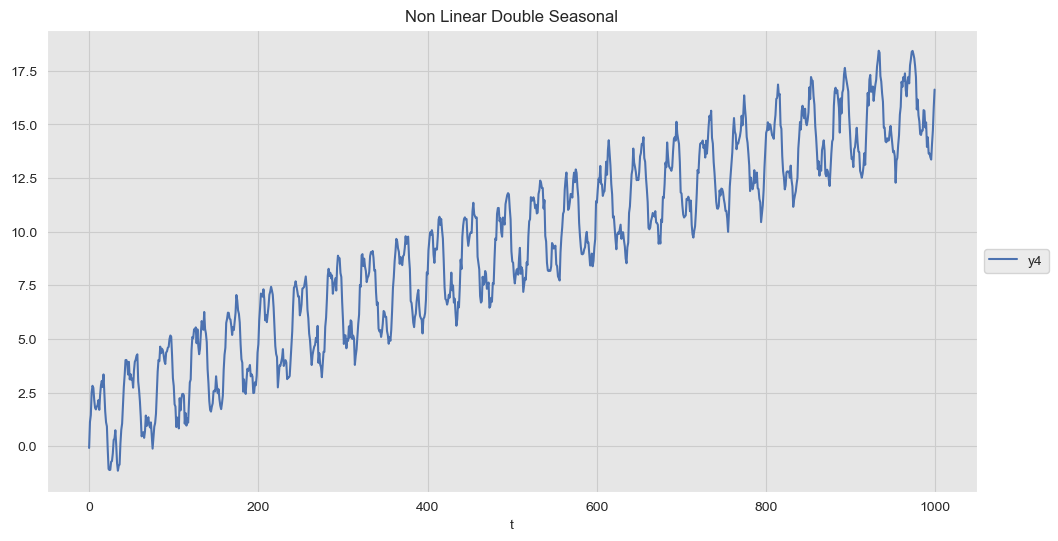

In [8]:
fig, ax = plt.subplots()
sns.lineplot(x='t', y='y4', data=data_df, color=sns_c[0], label='y4', ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Non Linear Double Seasonal', xlabel='t', ylabel='')

# Preprocessing

- Seasonal Decomposing

In [9]:
df = data_df[['t', 'y4']] # for double seasonal data with linear trend

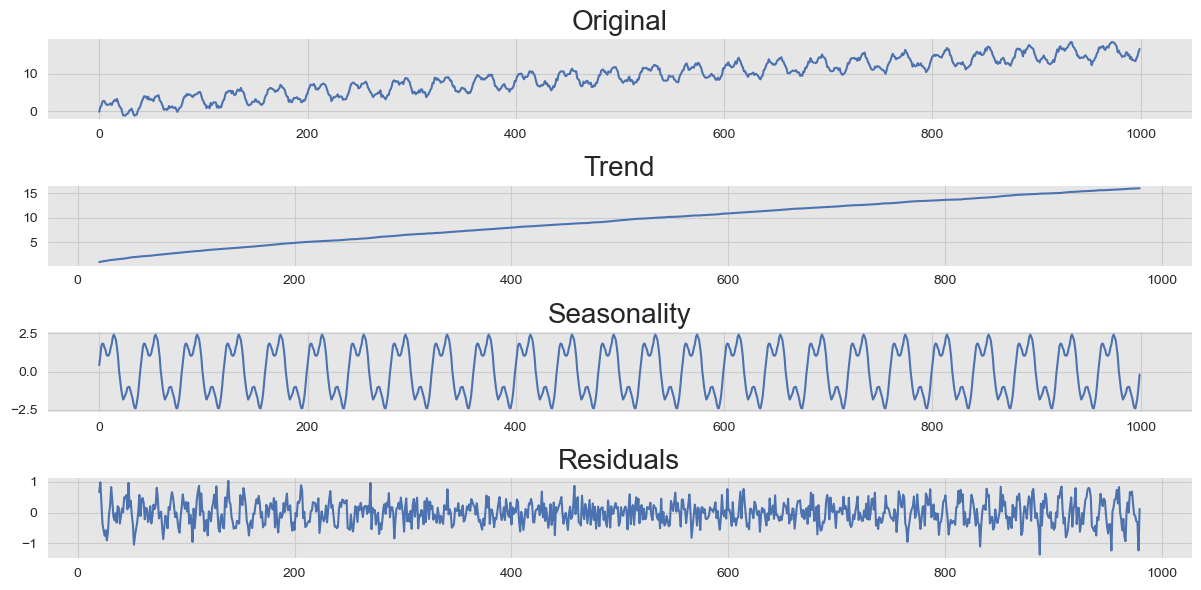

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

def seasonal_decompose_analysis(timeseries, model, periods):
    decomposition = seasonal_decompose(timeseries, model = model, period = periods)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.subplot(411)
    plt.title('Original', fontsize=20)
    plt.plot(timeseries, label='Original')
    plt.subplot(412)
    plt.title('Trend', fontsize=20)
    plt.plot(trend, label='Trend')
    plt.subplot(413)
    plt.title('Seasonality', fontsize=20)
    plt.plot(seasonal,label='Seasonality')
    plt.subplot(414)
    plt.title('Residuals', fontsize=20)
    plt.plot(residual, label='Residuals')
    plt.tight_layout()

seasonal_decompose_analysis(df['y4'], 'additive', 40)

We observe a seasonality of around 40

- Check Stationarity

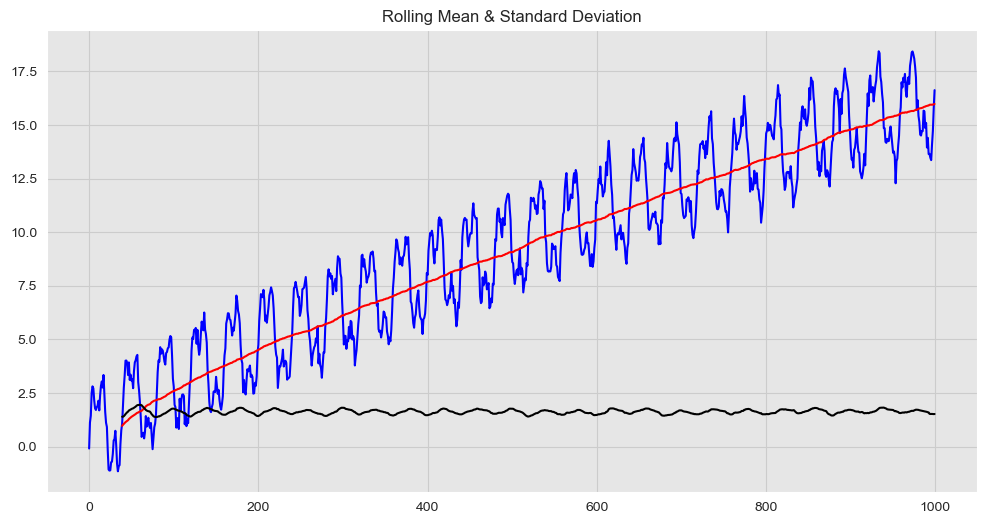

Results of Dickey-Fuller Test
Test Statistic                  -1.138081
p-value                          0.699649
#Lags Used                      22.000000
Number of Observations Used    977.000000
Critical Value (1%)             -3.437061
Critical Value (5%)             -2.864503
Critical Value (10%)            -2.568348
dtype: float64


In [11]:
from statsmodels.tsa.stattools import adfuller

def stationarity_test(timeseries, rolling_window):
    rolling_mean = timeseries.rolling(window=rolling_window).mean()
    rolling_std = timeseries.rolling(window=rolling_window).std()

    orig = plt.plot(timeseries, color='blue', label= 'Original')
    mean = plt.plot(rolling_mean, color='red', label= 'Rolling Mean')
    std = plt.plot(rolling_std, color='black', label = 'Rolling Std')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Dickey-Fuller test
    print('Results of Dickey-Fuller Test')
    test = adfuller(timeseries, autolag='AIC')
    output = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
        output['Critical Value (%s)'%key] = value
    print(output)
    
stationarity_test(timeseries = df['y4'], rolling_window = 40)

- p-value is greater than 0 (usually want it to be less than 0.05) => non-stationary
- remove stationarity

In [12]:
df.set_index('t', inplace=True)

- perform seasonal first difference

In [13]:
df['Seasonal First Difference'] = df['y4'] - df['y4'].shift(40)

C:\Users\Abhinav\AppData\Local\Temp\ipykernel_13280\2030051999.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Seasonal First Difference'] = df['y4'] - df['y4'].shift(40)


- perform dickey fuller test

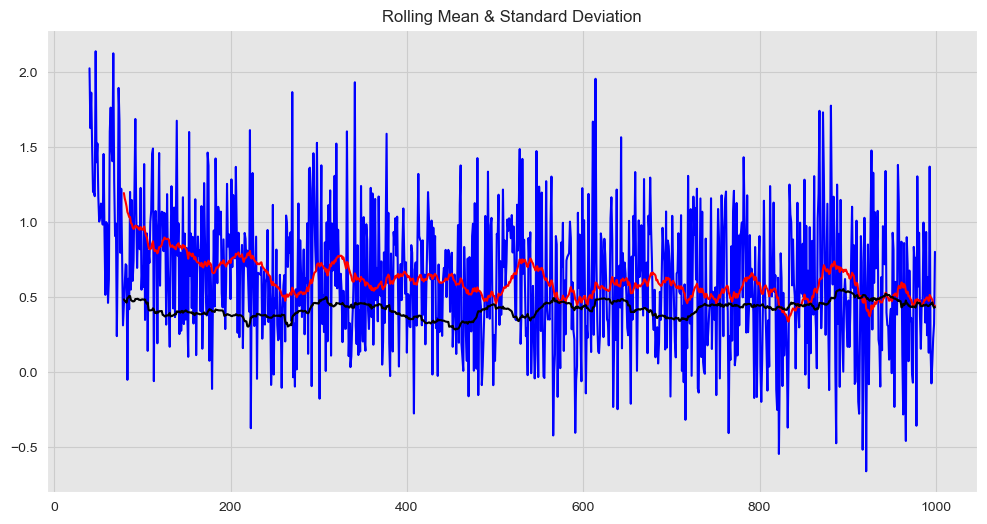

Results of Dickey-Fuller Test
Test Statistic                -8.052407e+00
p-value                        1.727905e-12
#Lags Used                     8.000000e+00
Number of Observations Used    9.510000e+02
Critical Value (1%)           -3.437245e+00
Critical Value (5%)           -2.864584e+00
Critical Value (10%)          -2.568391e+00
dtype: float64


In [14]:
stationarity_test(df['Seasonal First Difference'].dropna(),40)

- perform acf and pacf to determine parameters of SARIMAX

In [15]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

c:\Users\Abhinav\anaconda3\envs\timeSeries\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


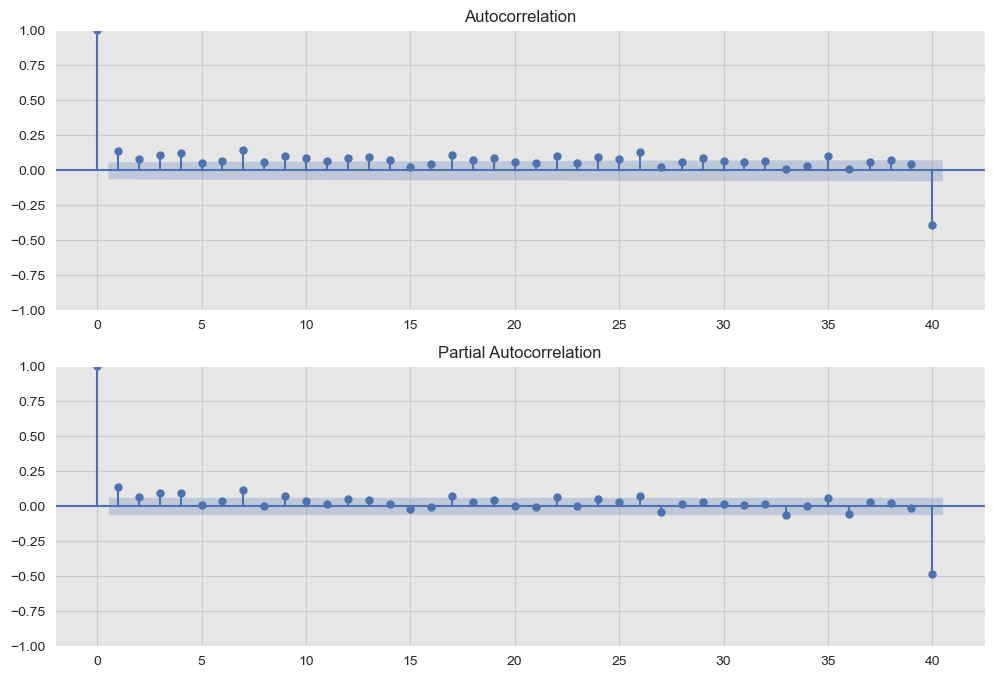

In [16]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['Seasonal First Difference'].iloc[40:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['Seasonal First Difference'].iloc[40:],lags=40,ax=ax2)

- autocorrelation graph tells us the AR lag p = 2
- partial autocorrelation graph tells us the MA lag q = 2
- we consider first order seasonal difference d = 1

- first we show that ARIMA does not work as data is seasonal

In [17]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(df['y4'],order=(2,1,2))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     y4   No. Observations:                 1000
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -669.925
Date:                Tue, 04 Apr 2023   AIC                           1349.851
Time:                        00:08:25   BIC                           1374.385
Sample:                             0   HQIC                          1359.176
                               - 1000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7735      0.004    444.201      0.000       1.766       1.781
ar.L2         -0.9919      0.004   -257.059      0.000      -0.999      -0.984
ma.L1         -1.7242      0.007   -245.381      0.000      -1.738      -1.710
ma.L2          0.9830      0.007    138.113      0.000       0.969       0.997
sigma2         0.2227      0.010     22.005      0.000       0.203       0.242
===================================================================================
Ljung-Box (L1) (Q):                  43.70   Jarque-Bera (JB):                 0.48
Prob(Q):                              0.00   Prob(JB):                         0.79
Heteroskedasticity (H):               1.14   Skew:                            -0.05
Prob(H) (two-sided):                  0.24   Kurtosis:                         2.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\Abhinav\AppData\Local\Temp\ipykernel_13280\1430777958.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['forecast']=model_fit.predict(start=900,end=1000,dynamic=True)


<Axes: xlabel='t'>

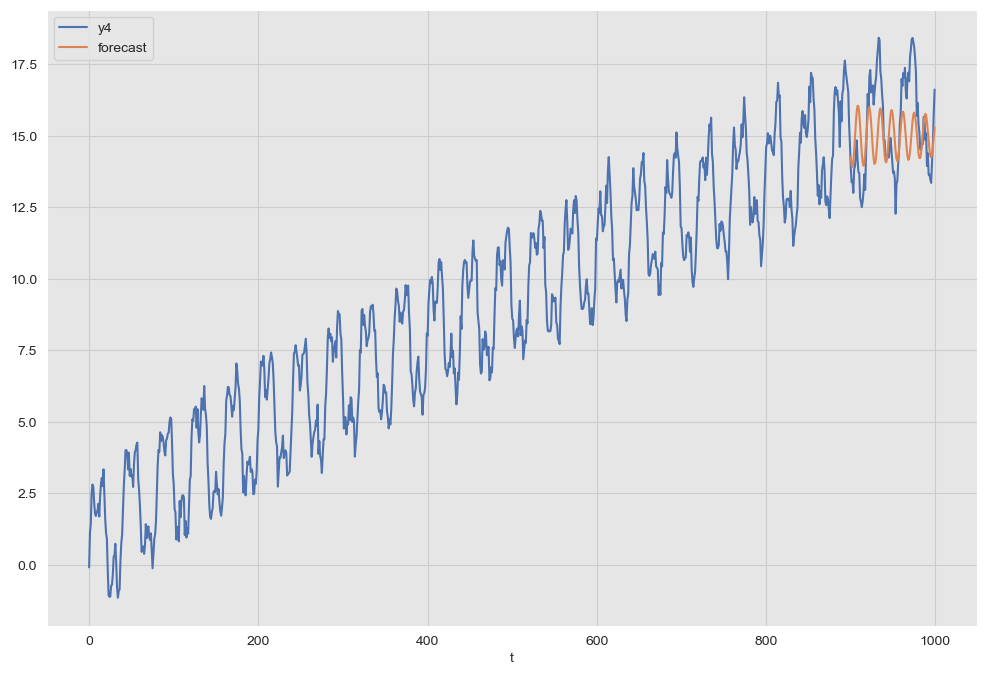

In [18]:
df['forecast']=model_fit.predict(start=900,end=1000,dynamic=True)
df[['y4','forecast']].plot(figsize=(12,8))

### next we use SARIMAX

In [19]:
prop_train = 0.7
n_train = round(prop_train * n)
sarimax_train = df['y4'][:n_train]
sarimax_test = df['y4'][n_train:]

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model=SARIMAX(sarimax_train,order=(2, 1, 2),seasonal_order=(2,1,2,40))
results=model.fit()
results.summary()

c:\Users\Abhinav\anaconda3\envs\timeSeries\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Abhinav\anaconda3\envs\timeSeries\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Abhinav\anaconda3\envs\timeSeries\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                 y4   No. Observations:                  700
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 40)   Log Likelihood                -244.442
Date:                            Tue, 04 Apr 2023   AIC                            506.885
Time:                                    00:09:42   BIC                            547.301
Sample:                                         0   HQIC                           522.552
                                            - 700                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7818      0.162     -4.826      0.000      -1.099      -0.464
ar.L2          0.0397      0.055      0.718      0.473      -0.069       0.148
ma.L1         -0.0658      0.157     -0.419      0.675      -0.373       0.242
ma.L2         -0.8160      0.150     -5.426      0.000      -1.111      -0.521
ar.S.L40      -0.7228      2.259     -0.320      0.749      -5.150       3.704
ar.S.L80      -0.0308      0.203     -0.152      0.879      -0.428       0.367
ma.S.L40       0.0213      2.263      0.009      0.993      -4.414       4.456
ma.S.L80      -0.4235      1.403     -0.302      0.763      -3.174       2.327
sigma2         0.1181      0.007     16.818      0.000       0.104       0.132
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                 1.96
Prob(Q):                              0.69   Prob(JB):                         0.37
Heteroskedasticity (H):               1.07   Skew:                             0.03
Prob(H) (two-sided):                  0.61   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
std_sarimax = np.sqrt(np.sum(np.power(results.bse, 2)))
df['forecast'] = results.predict(start=n_train,end=1000,dynamic=True)
df['std'] = std_sarimax
df['forecast_lwr'] = df['forecast'] - 2*df['std']
df['forecast_upr'] = df['forecast'] + 2*df['std']

C:\Users\Abhinav\AppData\Local\Temp\ipykernel_13280\2414317499.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['forecast'] = results.predict(start=n_train,end=1000,dynamic=True)
C:\Users\Abhinav\AppData\Local\Temp\ipykernel_13280\2414317499.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std'] = std_sarimax
C:\Users\Abhinav\AppData\Local\Temp\ipykernel_13280\2414317499.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

[Text(0.5, 1.0, 'Non Linear Double Seasonal'),
 Text(0.5, 0, 't'),
 Text(0, 0.5, '')]

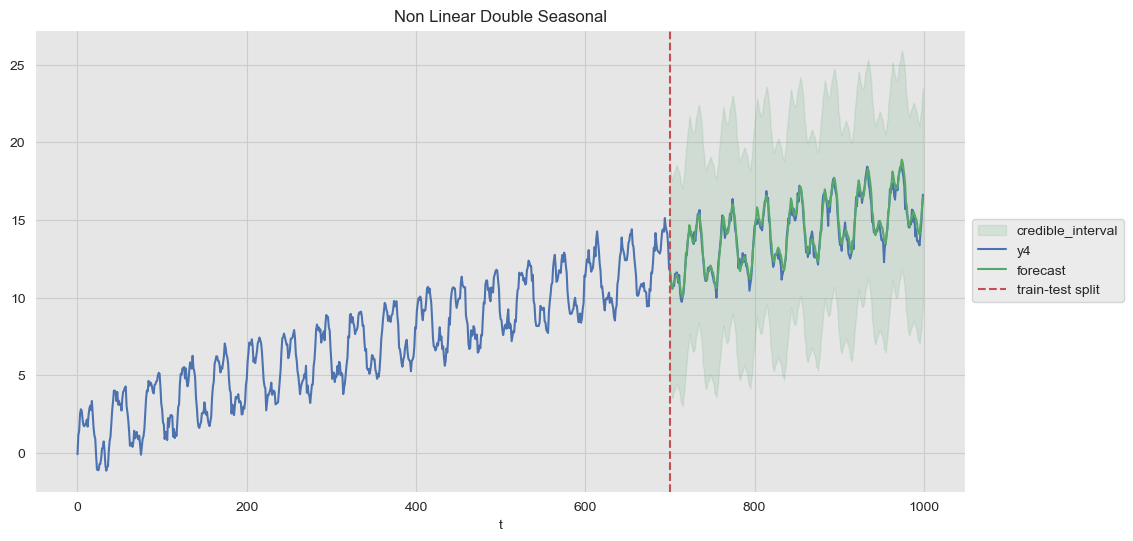

In [22]:
fig, ax = plt.subplots()

ax.fill_between(
    x=data_df['t'], 
    y1=df['forecast_lwr'], 
    y2=df['forecast_upr'], 
    color=sns_c[2], 
    alpha=0.15, 
    label='credible_interval'
)

sns.lineplot(x='t', y='y4', data=df, color=sns_c[0], label = 'y4', ax=ax)
sns.lineplot(x='t', y='forecast', data=df, color=sns_c[2], label='forecast', ax=ax)

ax.axvline(n_train, color=sns_c[3], linestyle='--', label='train-test split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Non Linear Double Seasonal', xlabel='t', ylabel='')

In [24]:
sarimax_pred = df['forecast'][n_train:].to_numpy().reshape((n-n_train,1))
sarimax_test = sarimax_test.to_numpy().reshape((sarimax_test.shape[0],1))

In [25]:
from sklearn.metrics import r2_score
sarimax_R2_score = r2_score(sarimax_test, sarimax_pred)
print(f'R2 Score Test = {sarimax_R2_score}')

R2 Score Test = 0.9505497577008587


In [26]:
from sklearn.metrics import mean_absolute_error
sarimax_MAE = mean_absolute_error(y_true=sarimax_test, y_pred=sarimax_pred)
print(f'MAE Test = {sarimax_MAE}')

MAE Test = 0.34825233020875523


c:\Users\Abhinav\anaconda3\envs\timeSeries\Lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Sarimax Model - Errors'),
 Text(0.5, 0, 'error'),
 Text(0, 0.5, '')]

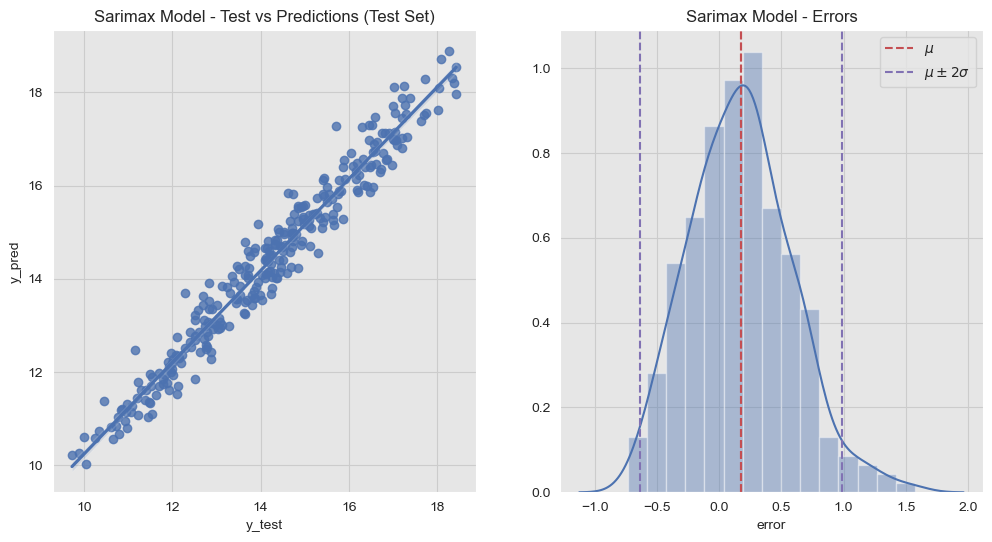

In [27]:
errors = sarimax_pred - sarimax_test
errors = errors.flatten()
errors_mean = errors.mean()
errors_std = errors.std()

fig, ax = plt.subplots(1, 2, figsize=(12, 6)) 
sns.regplot(x=sarimax_test.flatten(), y=sarimax_pred.flatten(), ax=ax[0])
sns.distplot(a=errors, ax=ax[1])
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--', label=f'$\mu$')
ax[1].axvline(x=errors_mean + 2*errors_std, color=sns_c[4], linestyle='--', label=f'$\mu \pm 2\sigma$')
ax[1].axvline(x=errors_mean - 2*errors_std, color=sns_c[4], linestyle='--')
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--')
ax[1].legend()
ax[0].set(title='Sarimax Model - Test vs Predictions (Test Set)', xlabel='y_test', ylabel='y_pred');
ax[1].set(title='Sarimax Model - Errors', xlabel='error', ylabel=None)

- future prediction

In [28]:
k = 5*40 # 5 more cycles
t = 1000 + np.arange(k)
future_df = pd.DataFrame({'t': t, 'y4': None, 'Seasonal First Difference': None, 'forecast': None})
future_df.set_index('t', inplace=True)

In [29]:
new_df = pd.concat([df, future_df])

In [30]:
std_sarimax = np.sqrt(np.sum(np.power(results.bse, 2)))
new_df['forecast'] = results.predict(start=n_train,end=1299,dynamic=True)
new_df['std'] = std_sarimax
new_df['forecast_lwr'] = new_df['forecast'] - 2*new_df['std']
new_df['forecast_upr'] = new_df['forecast'] + 2*new_df['std']

c:\Users\Abhinav\anaconda3\envs\timeSeries\Lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


In [31]:
temp = new_df.reset_index()

[Text(0.5, 1.0, 'Non Linear Double Seasonal'),
 Text(0.5, 0, 't'),
 Text(0, 0.5, '')]

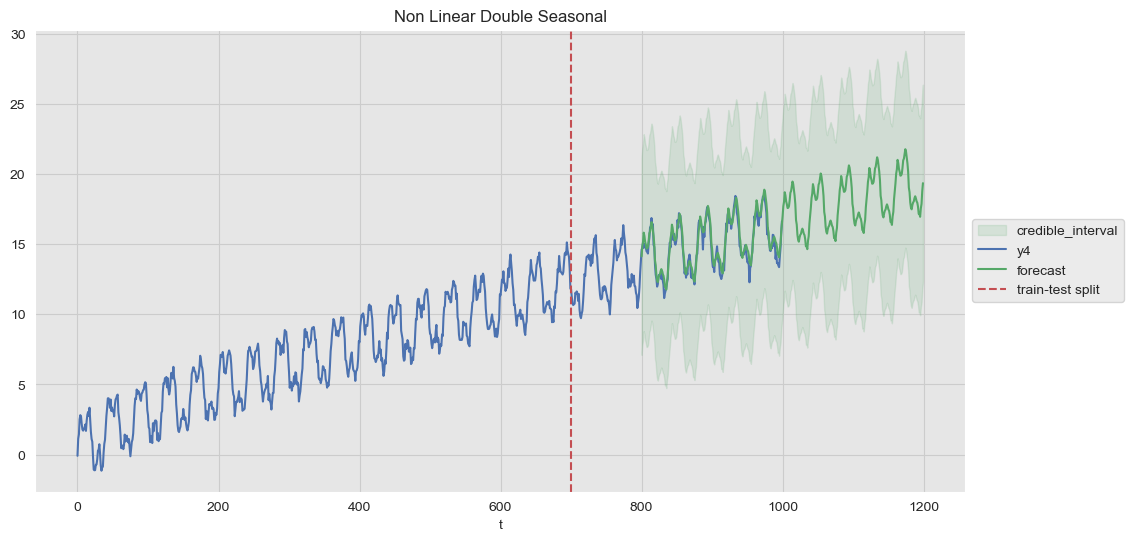

In [32]:
fig, ax = plt.subplots()

ax.fill_between(
    x=temp['t'], 
    y1=new_df['forecast_lwr'], 
    y2=new_df['forecast_upr'], 
    color=sns_c[2], 
    alpha=0.15, 
    label='credible_interval'
)

sns.lineplot(x='t', y='y4', data=new_df, color=sns_c[0], label = 'y4', ax=ax)
sns.lineplot(x='t', y='forecast', data=new_df, color=sns_c[2], label='forecast', ax=ax)

ax.axvline(n_train, color=sns_c[3], linestyle='--', label='train-test split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Non Linear Double Seasonal', xlabel='t', ylabel='')

## Gaussian Processes for Time-Series Forecasting 
### (A non-parametric model)


### Deciding kernels for the components of the data is the main part

In [33]:
from sklearn.gaussian_process.kernels import RationalQuadratic, RBF
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, ConstantKernel

# To model noise, noise_level = sigma**2
k0 = WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 0.5**2))

# To model periodic component, periodicity to be set as what is observed in data
k1 = ConstantKernel(constant_value=2) * \
  ExpSineSquared(length_scale=1.0, periodicity=40, periodicity_bounds=(35, 45))

# To model the trend component
# k2 = ConstantKernel(constant_value=25, constant_value_bounds=(1e-2, 1e3)) * \
#   RBF(length_scale=100.0, length_scale_bounds=(1, 1e4)) 

# To model the trend (non linear), its a scale mixture of RBF kernels
k2 = ConstantKernel(constant_value=100, constant_value_bounds=(1, 500)) * \
  RationalQuadratic(length_scale=500, length_scale_bounds=(1, 1e4), alpha= 50.0, alpha_bounds=(1, 1e3))

# To model another seasonal component
k3 = ConstantKernel(constant_value=1) * \
  ExpSineSquared(length_scale=1.0, periodicity=12, periodicity_bounds=(10, 15))

kernel_4  = k0 + k1 + k2 + k3

In [34]:
from sklearn.gaussian_process import GaussianProcessRegressor
# Define GaussianProcessRegressor object. 
gp4 = GaussianProcessRegressor(
    kernel=kernel_4, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0
)

In [35]:
X = data_df['t'].values.reshape(n, 1)

prop_train = 0.7
n_train = round(prop_train * n)

X_train = X[:n_train]
X_test = X[n_train:]

y = data_df['y4'].values.reshape(n ,1)
y_train = y[:n_train]
y_test = y[n_train:]

[Text(0.5, 1.0, 'GP3 Prior Samples'), Text(0.5, 0, 't')]

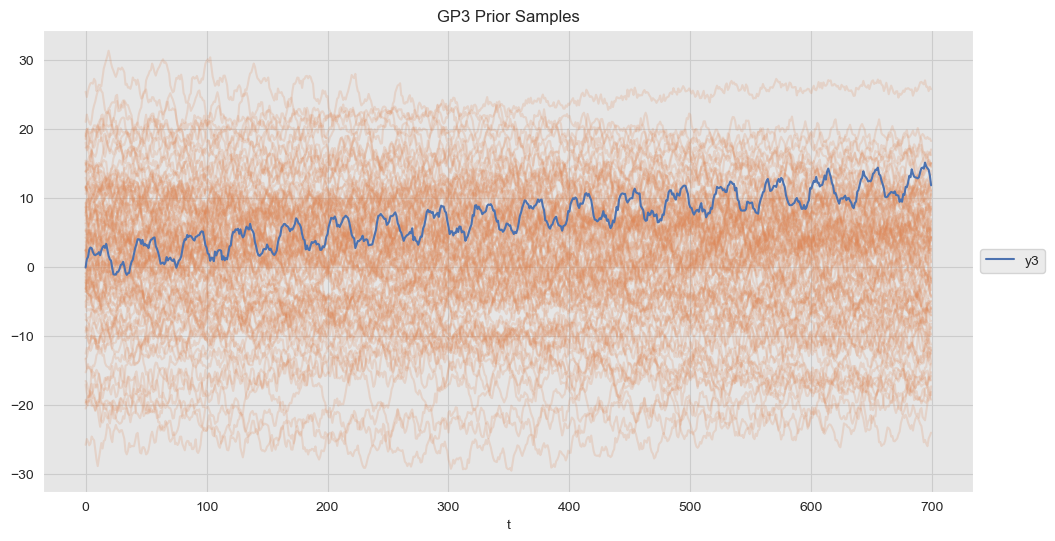

In [36]:
gp4_prior_samples = gp4.sample_y(X=X_train, n_samples=100)

fig, ax = plt.subplots()
for i in range(100):
    sns.lineplot(x=X_train[...,0], y = gp4_prior_samples[:, i], color=sns_c[1], alpha=0.2, ax=ax)
sns.lineplot(x=X_train[...,0], y=y_train[..., 0], color=sns_c[0], label='y3', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='GP3 Prior Samples', xlabel='t')

In [37]:
gp4.fit(X_train, y_train)

c:\Users\Abhinav\anaconda3\envs\timeSeries\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Abhinav\anaconda3\envs\timeSeries\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Abhinav\anaconda3\envs\timeSeries\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(

GaussianProcessRegressor(alpha=0.0,
                         kernel=WhiteKernel(noise_level=0.09) + 1.41**2 * ExpSineSquared(length_scale=1, periodicity=40) + 10**2 * RationalQuadratic(alpha=50, length_scale=500) + 1**2 * ExpSineSquared(length_scale=1, periodicity=12),
                         n_restarts_optimizer=10, normalize_y=True)

In [38]:
new_df2 = new_df.copy()
new_df2 = new_df2.reset_index()

In [39]:
gp_test = new_df2['t'].to_numpy().reshape((new_df2['t'].shape[0],1))

In [40]:
y_pred, y_std = gp4.predict(gp_test, return_std=True)

new_df2['forecast'] = y_pred
new_df2['std'] = y_std
new_df2['forecast_lwr'] = new_df2['forecast'] - 2*new_df2['std']
new_df2['forecast_upr'] = new_df2['forecast'] + 2*new_df2['std']

[Text(0.5, 1.0, 'Non Linear Double Seasonal'),
 Text(0.5, 0, 't'),
 Text(0, 0.5, '')]

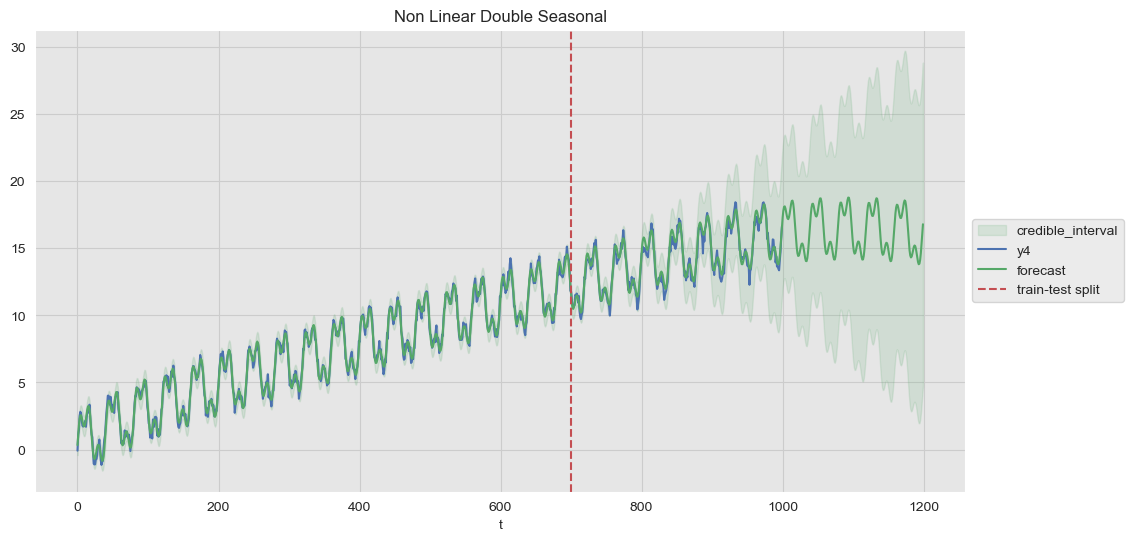

In [41]:
fig, ax = plt.subplots()

ax.fill_between(
    x=new_df2['t'], 
    y1=new_df2['forecast_lwr'], 
    y2=new_df2['forecast_upr'], 
    color=sns_c[2], 
    alpha=0.15, 
    label='credible_interval'
)

sns.lineplot(x='t', y='y4', data=new_df2, color=sns_c[0], label = 'y4', ax=ax)
sns.lineplot(x='t', y='forecast', data=new_df2, color=sns_c[2], label='forecast', ax=ax)

ax.axvline(n_train, color=sns_c[3], linestyle='--', label='train-test split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Non Linear Double Seasonal', xlabel='t', ylabel='')

In [42]:
from sklearn.metrics import mean_absolute_error
# print(f'R2 Score Train = {gp3.score(X=X_train, y=y_train): 0.3f}')
print(f'GP R2 Score Test = {gp4.score(X=X_test, y=y_test): 0.3f}')
print(f'SARIMAX R2 Score Test = {sarimax_R2_score: 0.3f}')

# print(f'MAE Train = {mean_absolute_error(y_true=y_train, y_pred=gp3.predict(X_train)): 0.3f}')
print(f'GP MAE Test = {mean_absolute_error(y_true=y_test, y_pred=gp4.predict(X_test)): 0.3f}')
print(f'SARIMAX MAE Test = {sarimax_MAE: 0.3f}')

GP R2 Score Test =  0.955
SARIMAX R2 Score Test =  0.951
GP MAE Test =  0.333
SARIMAX MAE Test =  0.348


c:\Users\Abhinav\anaconda3\envs\timeSeries\Lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Sarimax Model - Errors'),
 Text(0.5, 0, 'error'),
 Text(0, 0.5, '')]

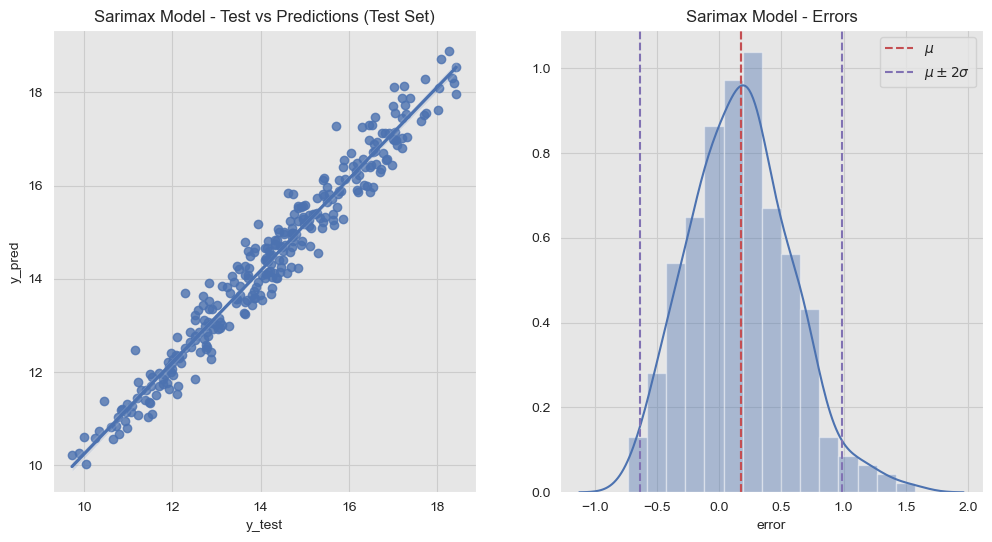

In [43]:
errors = sarimax_pred - sarimax_test
errors = errors.flatten()
errors_mean = errors.mean()
errors_std = errors.std()

fig, ax = plt.subplots(1, 2, figsize=(12, 6)) 
sns.regplot(x=sarimax_test.flatten(), y=sarimax_pred.flatten(), ax=ax[0])
sns.distplot(a=errors, ax=ax[1])
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--', label=f'$\mu$')
ax[1].axvline(x=errors_mean + 2*errors_std, color=sns_c[4], linestyle='--', label=f'$\mu \pm 2\sigma$')
ax[1].axvline(x=errors_mean - 2*errors_std, color=sns_c[4], linestyle='--')
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--')
ax[1].legend()
ax[0].set(title='Sarimax Model - Test vs Predictions (Test Set)', xlabel='y_test', ylabel='y_pred')
ax[1].set(title='Sarimax Model - Errors', xlabel='error', ylabel=None)

c:\Users\Abhinav\anaconda3\envs\timeSeries\Lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Model 3  - Errors'), Text(0.5, 0, 'error'), Text(0, 0.5, '')]

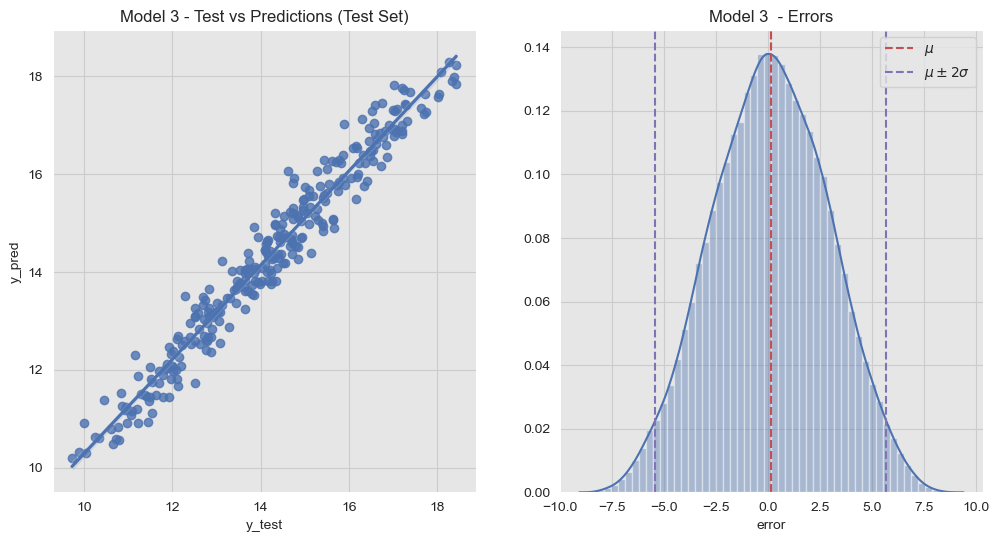

In [44]:
errors = gp4.predict(X_test) - y_test
errors = errors.flatten()
errors_mean = errors.mean()
errors_std = errors.std()

fig, ax = plt.subplots(1, 2, figsize=(12, 6)) 
sns.regplot(x=y_test.flatten(), y=gp4.predict(X_test).flatten(), ax=ax[0])
sns.distplot(a=errors, ax=ax[1])
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--', label=f'$\mu$')
ax[1].axvline(x=errors_mean + 2*errors_std, color=sns_c[4], linestyle='--', label=f'$\mu \pm 2\sigma$')
ax[1].axvline(x=errors_mean - 2*errors_std, color=sns_c[4], linestyle='--')
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--')
ax[1].legend()
ax[0].set(title='Model 3 - Test vs Predictions (Test Set)', xlabel='y_test', ylabel='y_pred')
ax[1].set(title='Model 3  - Errors', xlabel='error', ylabel=None)